<a href="https://colab.research.google.com/github/thaCripple/Simple-NNs/blob/main/tensflow%20SMS%20spam%20classification%20IntLabels/Tensorflow_NLP_SMS_spam_classification_int_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Classification with Tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sms_df = pd.read_csv("/content/Spam-Classification.csv")

# Quick Data Analysis

In [3]:
sms_df.head()

,CLASS,SMS
0,ham,"said kiss, kiss, i can't do the sound effects..."
1,ham,&lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4,spam,**FREE MESSAGE**Thanks for using the Auction S...


### Number of samples per class

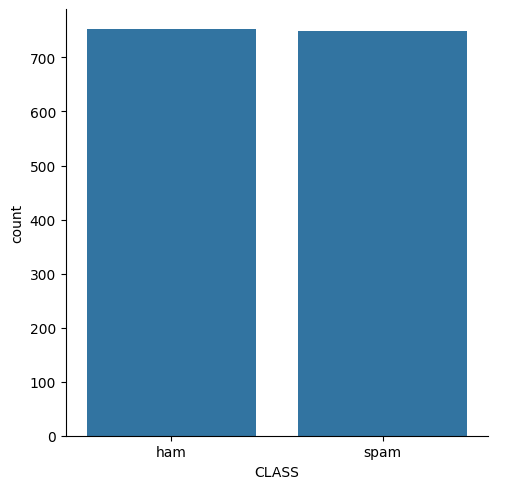

In [4]:
sns.catplot(kind="count", data=sms_df, x="CLASS")

### Number of words per sample

In [5]:
sms_df["words_per_sample"] = sms_df['SMS'].apply(func=lambda x: len(x.split()))

In [6]:
sms_df.head()

,CLASS,SMS,words_per_sample
0,ham,"said kiss, kiss, i can't do the sound effects...",27
1,ham,&lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.,8
2,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,22
3,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...,25
4,spam,**FREE MESSAGE**Thanks for using the Auction S...,23


## Number of Samples to Number of Words per Sample Ratio

In [7]:
sms_df.shape[0] / sms_df["words_per_sample"].mean()

78.4136056318394

# Data Preparation

In [8]:
sms_text_raw = sms_df['SMS'].copy()
sms_label_raw = sms_df['CLASS'].copy()

## Encode target labels with LabelEncoder

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
lbl_encoder = LabelEncoder()

In [11]:
sms_label_int = lbl_encoder.fit_transform(sms_label_raw)

In [12]:
sms_label_int[:5]

array([0, 0, 1, 1, 1])

In [13]:
lbl_encoder.inverse_transform(sms_label_int[:5])

array(['ham', 'ham', 'spam', 'spam', 'spam'], dtype=object)

## Create tf.Datasets for train, test and validation subset

In [15]:
import tensorflow as tf
from tensorflow import keras

In [16]:
sms_ds = tf.data.Dataset.from_tensor_slices((sms_text_raw, sms_label_int))

In [17]:
sms_ds_len = sms_ds.cardinality().numpy() # Size of the dataset

In [18]:
sms_ds.shuffle(buffer_size=sms_ds_len)

<_ShuffleDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
TRAIN_VAL_SIZE = int(.8 * sms_ds_len) # 20% of samples left for testing

In [20]:
train_val_ds = sms_ds.take(TRAIN_VAL_SIZE)
test_ds_raw = sms_ds.skip(TRAIN_VAL_SIZE)

In [21]:
VAL_SIZE = int(.2 * train_val_ds.cardinality().numpy()) # 20% of samples dedicated to validation during training

In [22]:
val_ds_raw = train_val_ds.take(VAL_SIZE)
train_ds_raw = train_val_ds.skip(VAL_SIZE)

In [23]:
print(f"""Training samples: {train_ds_raw.cardinality().numpy()}
Validation samples: {val_ds_raw.cardinality().numpy()}
Testing samples: {test_ds_raw.cardinality().numpy()}""")

Training samples: 960
Validation samples: 240
Testing samples: 300


### Create and adapt a Vectorization Layer

In [24]:
tf_idf_lyr = keras.layers.TextVectorization(
    ngrams=(1,2),
    output_mode="tf_idf",
    encoding='utf-8',
    name="tfidfLayer"
)

In [25]:
text_only = train_ds_raw.map(lambda x,y: x)

In [26]:
tf_idf_lyr.adapt(text_only)

In [29]:
# Batch and Prefetch datasets
BATCH_SIZE = 8
train_ds = train_ds_raw.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds_raw.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds_raw.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build the model

## Create a Sequential Model

In [51]:
model1 = keras.Sequential(name="Model1")
model1.add(tf_idf_lyr) # Feature vectorization will happen during training
model1.add(keras.layers.Dropout(rate=.2, name="Dropout1"))
model1.add(keras.layers.Dense(units=32, activation="relu", name="Dense1"))
model1.add(keras.layers.Dropout(rate=.2, name="Dropout2"))
model1.add(keras.layers.Dense(units=32, activation="relu", name="Dense2"))
model1.add(keras.layers.Dense(units=1, activation="sigmoid", name="Output"))

In [52]:
model1.summary()

Model: "Model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tfidfLayer (TextVectorization)       │ (None, 14508)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [54]:
stop1 = tf.keras.callbacks.EarlyStopping(patience=2)

## Train and evaluate the model

In [55]:
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[stop1])

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - binary_accuracy: 0.6400 - loss: 0.6381 - val_binary_accuracy: 0.9375 - val_loss: 0.2645
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9737 - loss: 0.1489 - val_binary_accuracy: 0.9250 - val_loss: 0.1906
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.9944 - loss: 0.0216 - val_binary_accuracy: 0.9333 - val_loss: 0.1945
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 1.0000 - loss: 0.0046 - val_binary_accuracy: 0.9292 - val_loss: 0.2367


In [56]:
model1.evaluate(x=test_ds)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9598 - loss: 0.0878


[0.14088495075702667, 0.9599999785423279]

In [57]:
sms1 = tf_idf_lyr(tf.constant(["I love python",
                               "WIN NOW! A trip of your dreams! Reply with YES to join the lottery!",
                               "Congratulations! You’ve won a $500 Amazon gift card. Claim it by calling 1-800-scam",
                               "We tried to call you re your reply to our sms for a free toaster + free camcorder. Please call now 784954987 for delivery!"]))

In [58]:
sms1 = tf.constant(["I love python",
                    "WIN NOW! A trip of your dreams! Reply with YES to join the lottery!",
                               "Congratulations! You’ve won a $500 Amazon gift card. Claim it by calling 1-800-scam",
                               "We tried to call you re your reply to our sms for a free toaster + free camcorder. Please call now 784954987 for delivery!"])

In [59]:
sms1_predictions = model1.predict(x=sms1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [60]:
sms1_predictions = (sms1_predictions > .5).astype("int").ravel()

In [61]:
lbl_encoder.inverse_transform(sms1_predictions)

array(['ham', 'spam', 'spam', 'spam'], dtype=object)

## Plot the training history

In [62]:
def plot_history(history, figsize=(12,8)):
  """
  Plots the Accuracy and Loss history collected during model training.

  Parameters:
    history: <history.History>
      Object returned by a models' .fit() method

    figsize: tuple(width, height); default=(12,8)
      Size of the matplotlib figure to be drawn

  Raises:
    Exception: when the passed history object doesn't contain
    exactly 4 entries

  Returns: None

  """

  # Check if matplotlib has been imported
  if "plt" not in globals():
    import matplotlib.pyplot as plt

  # Extract a dictionary from the history object
  history = history.history
  # Check if history is of correct size
  history_items = list(history.items())
  if len(history_items) != 4:
    raise Exception("History must contain 4 entries")

  n_epochs = range(1, len(history_items[0][1]) + 1)
  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  # Plot Accuracy
  axes[0].plot(n_epochs, history_items[0][1], label=history_items[0][0], color="blue")
  axes[0].plot(n_epochs, history_items[2][1], label=history_items[2][0], color="green")
  axes[0].set(xlabel="Epoch", ylabel="Accuracy")
  axes[0].set_title("Training and Validation Accuracy", fontsize="x-large")
  axes[0].grid(visible=True)
  axes[0].legend()

  # Plot Loss
  axes[1].plot(n_epochs, history_items[1][1], label=history_items[1][0], color="blue")
  axes[1].plot(n_epochs, history_items[3][1], label=history_items[3][0], color="green")
  axes[1].set(xlabel="Epoch", ylabel="Loss")
  axes[1].set_title("Training and Validation Loss", fontsize="x-large")
  axes[1].grid(visible=True)
  axes[1].legend()

  fig.suptitle("Training History", fontsize="xx-large", y=1.02)
  fig.show()

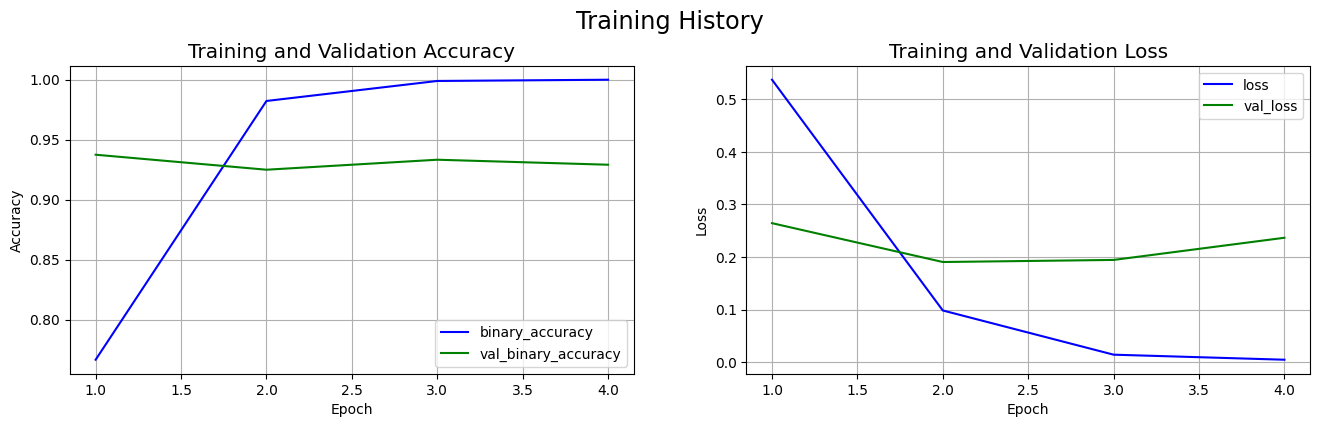

In [63]:
plot_history(history=history, figsize=(16,4))